<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/main.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img/colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/main.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/magdasalatka/fantasticfeatures/blob/main/main.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# Back to the Feature
### boost your model with statistical feature engineering

by [Teresa Kubacka](http://teresa-kubacka.com/), [Magdalena Surówka](https://datali.ch)

AMLD 2021, 26.10.2021

In [ ]:
!pip install -U git+https://github.com/magdasalatka/fantasticfeatures.git

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as sg

from fantasticfeatures.plotting import plot_x_vs_y, plot_x_over_time, plot_fitted_vs_residuals, calculate_variances, plot_residuals_distribution
# from fantasticfeatures.dataset_noise_generator import *

C:\Users\TK\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Model diagnostics

Regression has some assumptions about its errors, *e<sub>i</sub>*. 
These assumptions are:

 * E[*e<sub>i</sub>*] = 0
 * Var(*e<sub>i</sub>*) = &sigma;<sup>2</sup>
 * *e<sub>i</sub>* ~ *N*(0, &sigma;<sup>2</sup>)
 * Cov(*e<sub>i</sub>*, *e<sub>j</sub>*) = 0

 Additioanlly, we also assume:
 * no multicollinearity in regressors

The first three conditions are necessary to perform a least square estimation and to have valid fitted values.  
The last condition is only required for any hypothesis tests, confidence intervals and prediction intervals. 

As you can see, most of our assumptions are about errors. However, errors cannot be observed in practice. Instead, we well be working with residuals, which are only estimates of the errors. They have however, an estimation-related issue.   
In regression, the variances of the residuals at different input variable values may differ. This can happen even if the variances of the errors at these different input variable values are equal.   

To improve the results, we can standardize or [studentize](https://en.wikipedia.org/wiki/Studentized_residual) the residuals.

## 1.1 Sample model
Let's fit a sample model, and take a look at its fit.

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/ex1/interesting_data.csv", index_col=0)
y = df.y.to_numpy()
X = df.loc[:, df.columns != 'y'].to_numpy()

threshold = int(len(X)*0.8)
X_train, X_test = X[:threshold], X[threshold:]
y_train, y_test = y[:threshold], y[threshold:]

predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
fitted = model.predict(predictors)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:48:21   Log-Likelihood:                -3342.4
No. Observations:                 800   AIC:                             6697.
Df Residuals:                     794   BIC:                             6725.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4840      0.561     18.688      0.0

What do all these entries mean? Let's jump to another notebook: [local](./statsmodels_summary.ipynb) [html](https://github.com/magdasalatka/fantasticfeatures/blob/main/statsmodels_summary.ipynb) [Colab](https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/statsmodels_summary.ipynb)

## 1.2 Assumption 1
E[*e<sub>i</sub>*] = 0

In other words, on average the errrors should be zero

In [15]:
residuals_raw = fitted - y_train
residuals = residuals_raw/np.std(residuals_raw)
print("Expected error estimate: {}".format(sum(residuals)/len(residuals)))

Expected error estimate: -2.129720011456726e-15


In [16]:
# in the next step, you will notice we are using some custom plotting functions. You can inspect their code like this: 
import inspect
print(inspect.getsource(plot_x_vs_y))
# if you want to write your own / modify them, write them directly in the notebook

def plot_x_vs_y(
    x: np.ndarray,
    y: np.ndarray,
    x_name: str = "x_name",
    y_name: str = "y_name",
    add_zero_line: bool = False,
    add_lowess: bool = False,
    model=None,
    hexbin: bool = False,
    figsize=None,
    ax=None,
    lowess_param=0.2,
    plot_args={},
) -> None:
    if ax is None:
        _, axs = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
        this_ax = axs
    else:
        this_ax = ax

    if hexbin:
        this_ax.hexbin(x, y, cmap="Greys", gridsize=40, **plot_args)
    else:
        scatter_defaults = {"alpha": 0.25, "s": 20, "edgecolors": None}
        for k, v in scatter_defaults.items():
            if k not in plot_args.keys():
                plot_args[k] = v
        this_ax.scatter(x, y, lw=0, **plot_args)

    xlabel = x_name
    this_ax.set_xlabel(xlabel)
    this_ax.set_ylabel(y_name)
    this_ax.grid(True)
    if add_zero_line:
        this_ax.hlines(0, xmin=min(x), xmax=max(x), colors="magenta")
    if add_lowess

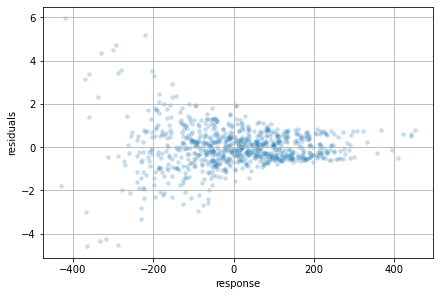

In [17]:
plot_x_vs_y(fitted, residuals, "response", "residuals")

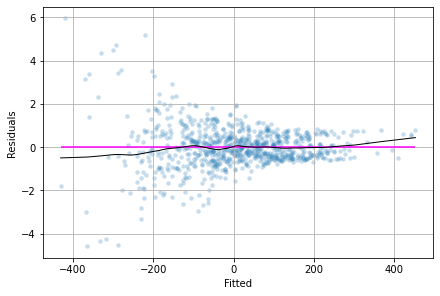

In [18]:
plot_x_vs_y(fitted, residuals, "Fitted", "Residuals", add_zero_line=True, add_lowess=True)

Failing assumption implies systematic error. This means:
* the relationship between response and regressors may be nonlinear
* some important regressors may be missing
* some important interactions may be missing

## 1.3 Assumption 2

Var(*e<sub>i</sub>*) = &sigma;<sup>2</sup>

In other words: variance of residuals should be constant

### 1.3.1 Fitted vs residuals: heteroskedasticity check

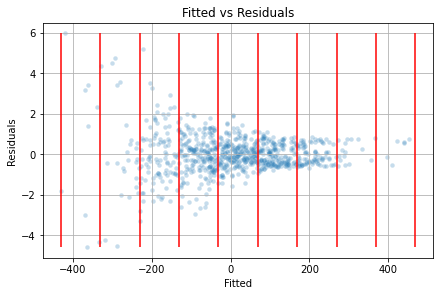

In [19]:
plot_fitted_vs_residuals(fitted, residuals, mean=False, width=100, bin_type='window')
# here we can either slice it by a window with a predefined width, or by a slice containing number of points. 
# Try bin_type="points" for the second option. 

### 1.3.2 Residuals: heteroskedasticity check

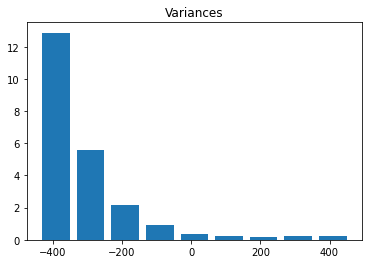

In [21]:
# Try different widths and bin types - what happens? 

bins, variances, counts = calculate_variances(fitted, residuals, 100, bin_type="window")

# want to know what calculate_variances() does exactly? uncomment the following: 
# print(inspect.getsource(calculate_variances))

plt.bar(bins, variances, width=np.diff(bins).min()*0.8, align='edge')
plt.title('Variances')
plt.show()


Failing assumption implies heteroskedasticity. This means:
* the error estimates are not valid =>
* the confidence intervals are not valid =>
* p-values are not valid
* coefficients **are valid**  

In short: your expected value remains unchanged. But you have no viable insights on model unsertanity.

## 1.4 Assumption 3
*e<sub>i</sub>* ~ *N*(0, &sigma;<sup>2</sup>)

In other words: residuals are normally distributed

### 1.4.1 Empirical distribution

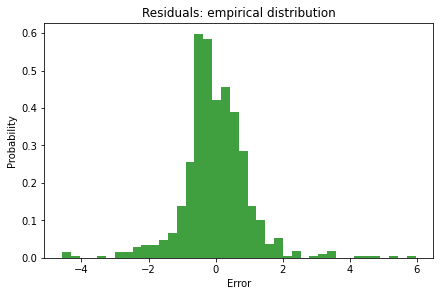

In [22]:
plot_residuals_distribution(residuals, bins=40)

### 1.4.2 QQ-plot

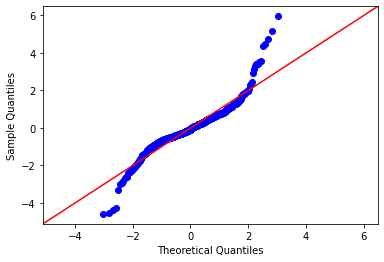

In [23]:
fig = sm.qqplot(residuals/np.std(residuals), line='45')

Failing assumption implies systematic deviation. This means:
* model is failing to capture certain range of values
* model structure is not correct

In practice:
* few data points that are slightly "off the line" near the ends common, and usually tolerable
* skewed residuals need correction
* long-tailed, but symmetrical residuals are can be tolerable

## 1.5 Assumption 4
Cov(*e<sub>i</sub>*, *e<sub>j</sub>*) = 0

In other words: errors are not correlated **WITH EACH OTHER**


### 1.5.1 Residuals over time

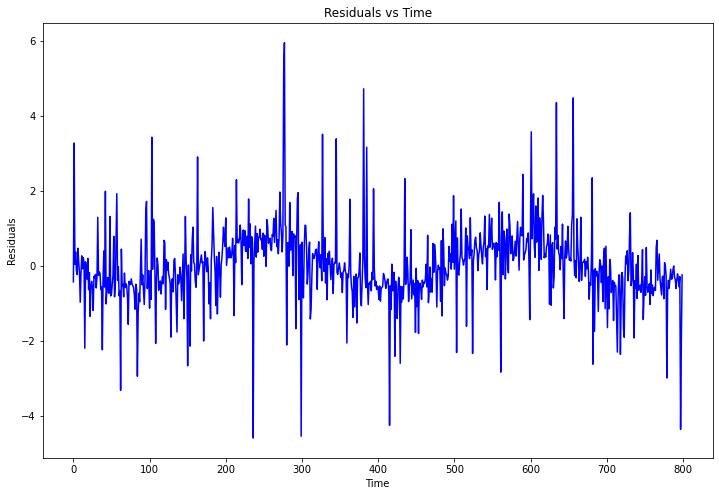

In [24]:
plot_x_over_time(residuals, "Residuals")

### 1.5.2 ACF plot
Check residuals vs lagged residuals

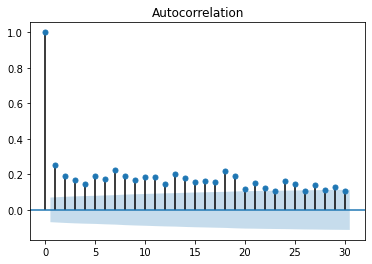

In [25]:
fig = sg.tsaplots.plot_acf(residuals)

Failing assumption means:
* estimates are unbiased => expected value for coefficients and predictions is ok
* the estimate is not efficient => there are better regression models 
* standard errors are biased => confidence intervals, test statistics, and p-values are flawed


## 1.6 Assumption 5 (Optional)
No multicollinearlty

Regression does not have a unique solution if regressors are exactly linearly dependent. Often, we will find not perfect, but a strong correlation between variables. Multicollinearity means that there is such strong, yet not perfect, relation between the columns of X.

Under multicollinity, unique solution exists. However, it performs poorly in practice. 

### 1.6.1 Correlation plot

In [ ]:
def plot_correlations(X: np.ndarray) -> None:
    df = pd.DataFrame(X)

    f = plt.figure(figsize=(8, 8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

plot_correlations(X_train)

Multicollinearlity means:
* estimated coefficients have large standard errors
* the coefficients are imprecise
* it happens that none of the regressors is significant!
* small change in data can result in big change in results

# Exercise 1: Model diagnostics

In this exercise, we will practice model diagnostics. 

In [26]:
# Datasets: https://github.com/magdasalatka/fantasticfeatures/tree/main/data/ex1 

url_prefix = "https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/ex1/{}"
datafile = "mystery_nonlinear_1.csv" # etc. 
print(url_prefix.format(datafile))

# your_df = pd.read_csv(url_prefix.format(datafile) ... )

https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/ex1/mystery_nonlinear_1.csv


Extra question: What could you do to make your investigation more efficient? 

___

# Exercise 2:  Transformations

## Transformations

The idea behing data trasformations is to achieve a mean function that is linear in the transformed scale.

The most commonly used methods to transform variables are:
* Logarithmic transformation - np.log(X)
* Reciprocal transformation - 1 / X
* Square root transformation - X**(1/2)
* Exponential transformation (more general, you can use any exponent)
* Box-Cox transformation

Let's explore this in another notebook: [local](./transformations.ipynb) [html](https://github.com/magdasalatka/fantasticfeatures/blob/main/transformations.ipynb) [Colab](https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/transformations.ipynb)

## Exercise

In this exercise, we will practice variables transformation. 

First, load datasets from `data/ex1`.  
Then, for each dataset:  
* fit linear model: y = f(x) + e  
* calculate residuals  
* perform model diagnostics  
* try to improve your model using data transformations  

In [28]:
# Datasets: https://github.com/magdasalatka/fantasticfeatures/tree/main/data/ex1 

url_prefix = "https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/ex1/{}"
datafile = "mystery_nonlinear_1.csv" # etc. 
print(url_prefix.format(datafile)) 

https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/ex1/mystery_nonlinear_1.csv


In [ ]:
# Load data

# Your code


___ 

# Exercise 3: Fit your best model

Now, we will wrap it all together. Let's try to fit our best model to the dataset about rental prices.  
The data is available in `data/other/rent.csv`.

Procedure:
* Maka a model hypothesis
* Fit a model
* Run model diagnostics
* Start again

In [27]:
ex3_data_url = "https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/data/other/rent.csv"

In [ ]:
# Your code


___

# Extra content

#### How do the errors on predictors influence the outcome of the regression? 

Let's explore this in another notebook: [local](./noise-on-y_vs_noise-on-y.ipynb) [html](https://github.com/magdasalatka/fantasticfeatures/blob/main/noise-on-y_vs_noise-on-y.ipynb) [Colab](https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/noise-on-y_vs_noise-on-y.ipynb)

#### How do different distributions of errors on y are represented on the qq-plots? 

Let's explore this in another notebook: [local](./noise-on-y_different-distributions.ipynb) [html](https://github.com/magdasalatka/fantasticfeatures/blob/main/noise-on-y_different-distributions.ipynb) [Colab](https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/noise-on-y_different-distributions.ipynb)

#### How to generate synthetic data? 

Let's explore this in another notebook: [local](./how-to_synthetic-data.ipynb) [html](https://github.com/magdasalatka/fantasticfeatures/blob/main/how-to_synthetic-data.ipynb) [Colab](https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/how-to_synthetic-data.ipynb)